In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

from ase.build import bulk
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

import pickle

/home/valeria/anaconda3/lib/python3.9/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


#### Porpose of this code
Evaluate the energy of the system using OFDFT with the $\rho_{0}$'s found in the code named rho0_dT.
In this code we won't use the KS electron density, we will perform a fully OF calculation with the corrected Wang-Teter KEDF to obtain the equation of states graph.

In [2]:
path_pp='/home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

In [3]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "Total energy" in match]
    KS_te = str(k).split()[6]
    KS_TE.append(float(KS_te)) 

In [4]:
rho00 = np.load('/home/valeria/Documents/DFTPY/Fitting_densities/Si-fcc/DATA2/rho0.npy')

In [ ]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho00)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

ENERGY = []
VOLUME = []
for n in np.arange(0, 30, 1):
        i = int(n)
        
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(bulk('Si', 'fcc', a= 3.405, cubic=True))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)

        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        
        energy = evaluator.Energy(rho=rho, ions=ions)
        vol=ions.get_volume()
        
        ENERGY.append(energy)
        VOLUME.append(vol)

setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf


[-6.06559447e-05 -1.02542604e-04 -1.37820943e-04 -1.20387670e-04
 -1.29936935e-04 -1.69550284e-04 -1.69807263e-04 -2.38718371e-04
 -2.47402351e-04 -2.21793821e-04]


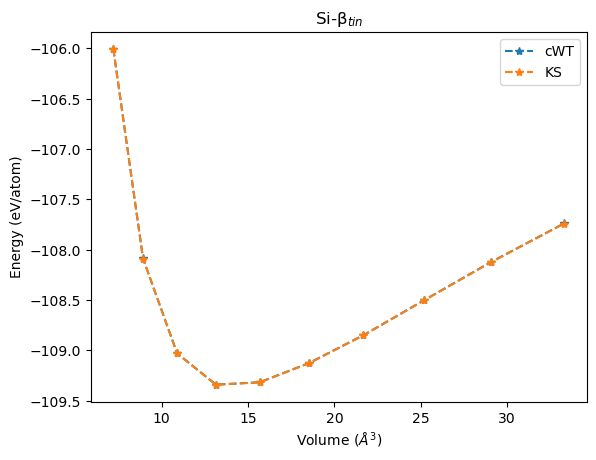

In [6]:
plt.plot(np.asarray(VOLUME)*0.529177**3/4,(np.asarray(ENERGY))*27.211407/4,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/4, np.asarray(KS_TE)*27.211407/8,'*--')
plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si-\u03B2$_{tin}$')
plt.legend(['cWT','KS'])
print((np.asarray(KS_TE)*1/2)-(np.asarray(ENERGY)))